In [1]:
# RNN for iEEG data
# data from  http://ieeg-swez.ethz.ch/
# Segessenmann J. 2020

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd

## Load and prepare data

In [14]:
# parameters
ch_start = 0  # first channel of used channels
ch_end = 66  # last channel of used channels
nr_samples = 2000  # the first nr_samples are used
window_size = 50
ch_out = [63, 64, 65]  # index of output channels (others are considered input)
normalization = True

data_mat = loadmat('./data/ID02_1h.mat')
data_raw = data_mat['EEG'][ch_start:ch_end, :nr_samples].transpose()

if normalization:
    sc = MinMaxScaler(feature_range=(-1, 1))
    sc.fit(data_raw)
    data = sc.transform(data_raw)

# to tensor
data = torch.FloatTensor(data)

# split data
train_portion = 0.8
train_set = data[:int(train_portion * nr_samples), :]
test_set = data[int(train_portion * nr_samples):, :]

# prepare data for learning
ch_in = list(range(ch_start, ch_end))
for idx, val in enumerate(ch_out):
    ch_in.remove(val)
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, ch_out])
    Y_train.append(train_set[i+window_size-1, ch_out])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, ch_in])
    Y_test.append(test_set[i+window_size-1, ch_out])

In [15]:
print(X_train[0].shape)
print(Y_train[0].shape)
print(train_set[50,:].shape)
print(X_train[0][-1,:])
print(Y_train[0])
print(train_set[49,:])

torch.Size([50, 66])
torch.Size([3])
torch.Size([66])
tensor([-5.9643e-01, -7.2316e-01, -7.3959e-01, -7.2662e-01, -7.1423e-01,
        -7.5241e-01, -8.8222e-01, -9.0980e-01, -6.7348e-01, -6.6223e-01,
         3.8345e-02,  4.9602e-01,  2.8728e-01,  1.3851e-01,  2.4195e-02,
        -5.4291e-02, -2.6053e-03, -2.2641e-02, -1.6695e-01, -2.5470e-01,
        -1.5377e-01,  3.6662e-01,  7.1027e-01,  6.8478e-01, -5.7943e-01,
        -7.0065e-01, -6.8216e-01, -6.0420e-01, -5.9795e-01, -7.2369e-01,
        -5.3381e-01, -5.8973e-01, -3.7251e-01,  9.2135e-01,  2.5180e-01,
         2.5162e-01,  3.9558e-02, -3.0805e-02, -1.6267e-01, -3.2361e-01,
        -3.9816e-01, -5.0328e-01, -4.4356e-01, -4.3579e-01, -5.9096e-01,
        -8.3297e-01, -9.3352e-01, -9.4963e-01,  6.3718e-01,  8.8341e-01,
         6.1027e-01,  2.9679e-01,  4.3097e-01,  2.0685e-01,  6.7187e-02,
        -1.5971e-01, -2.3465e-01, -1.8610e-01,  7.7070e-01,  6.5757e-01,
         3.5715e-01,  3.4345e-01,  2.0843e-01,  2.2720e-01,  1.4284e-0

## RNN Model

#### Bio RNN

In [49]:
class RNN(nn.Module):
    def __init__(self, input_size=len(ch_in), hidden_size=10, output_size=len(ch_out), channel_out=ch_out):
        super().__init__()
        # Variables
        self.hidden_size = hidden_size
        self.channel_out = channel_out
        # Layers
        self.rnn = nn.RNN(input_size, hidden_size)
        # Initializations
        self.hidden = torch.zeros(1, 1, self.hidden_size)

    def forward(self, X):
        out_rnn, self.hidden = self.rnn(X.view(X.shape[0], 1, X.shape[1]), self.hidden)
        Y = out_rnn.view(len(X), -1)
        return Y[-1, [3, 5, 7]]  # last value of each output channel

#### Normal RNN

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size=len(ch_in), hidden_size=10, output_size=len(ch_out)):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        # Initialize h0 (hidden state)
        self.hidden = torch.zeros(1, 1, self.hidden_size)

    def forward(self, X):
        out_rnn, self.hidden = self.rnn(X.view(X.shape[0], 1, X.shape[1]), self.hidden)
        Y = self.linear(out_rnn.view(len(X), -1))
        return Y[-1, :]  # last value of each output channel

#### Bio FFNN

In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_size=len(ch_in), hidden_size=20):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
            
        self.fc1 = nn.Linear(28 * 28, 200)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

## Training

Epoch: 0 Loss: 0.07105424161502837
Epoch: 1 Loss: 0.04927021868628799
Epoch: 2 Loss: 0.040159555808299614
Epoch: 3 Loss: 0.03505793220048322
Epoch: 4 Loss: 0.031675971699503216
Epoch: 5 Loss: 0.0292588634235164
Epoch: 6 Loss: 0.027452931737876655
0.7201599518458048


(Text(0.5, 0, 'epoch'), Text(0, 0.5, 'loss'))

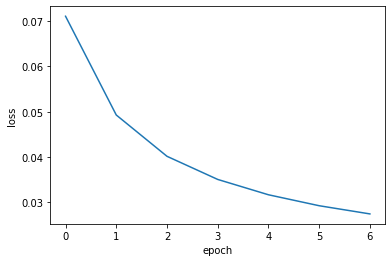

In [50]:
model = RNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 7

start_time = time.time()
temp_loss = []
epoch_loss = []

for epoch in range(epochs):
    for idx, X in enumerate(X_train):
        optimizer.zero_grad()
        model.hidden = torch.zeros(1, 1, model.hidden_size)
        Y_pred = model(X)
        loss = criterion(Y_pred, Y_train[idx])
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())

    epoch_loss.append(np.mean(np.asarray(temp_loss)))
    print(f'Epoch: {epoch} Loss: {epoch_loss[epoch]}')

total_time = time.time() - start_time
print(total_time / 60)

plt.figure()
plt.plot(np.asarray(epoch_loss))
plt.xlabel('epoch'), plt.ylabel('loss')

## Evaluation

In [51]:
model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        model.hidden = torch.zeros(1, 1, model.hidden_size)
        Y_preds.append(model(X).numpy())        

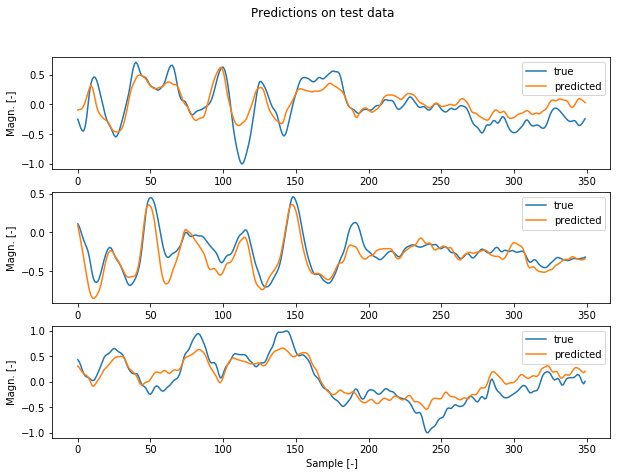

In [52]:
preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(3, figsize=(10, 7))
fig.suptitle('Predictions on test data')
ax[0].plot(Y_test_np[:,0], label='true')
ax[0].plot(preds[:,0], label='predicted')
ax[0].set_ylabel('Magn. [-]')
ax[0].legend()
ax[1].plot(Y_test_np[:,1], label='true')
ax[1].plot(preds[:,1], label='predicted')
ax[1].set_ylabel('Magn. [-]')
ax[1].legend()
ax[2].plot(Y_test_np[:,2], label='true')
ax[2].plot(preds[:,2], label='predicted')
ax[2].set_ylabel('Magn. [-]'), ax[2].set_xlabel('Sample [-]')
ax[2].legend()
fig.savefig('fig_0422_predictions_rnn.png')

In [34]:
[(para[0],para[1].shape) for para in list(model.rnn.named_parameters())]

[('weight_ih_l0', torch.Size([80, 63])),
 ('weight_hh_l0', torch.Size([80, 80])),
 ('bias_ih_l0', torch.Size([80])),
 ('bias_hh_l0', torch.Size([80]))]

In [53]:
weight_ih = list(model.rnn.named_parameters())[0][1].detach().numpy()
weight_hh = list(model.rnn.named_parameters())[1][1].detach().numpy()
bias_ih = list(model.rnn.named_parameters())[2][1].detach().numpy()
bias_hh = list(model.rnn.named_parameters())[3][1].detach().numpy()
#weight_ho = model.fc2.weight.detach().numpy()
#bias_ho = model.fc2.bias.detach().numpy()
print(weight_ih.shape, weight_hh.shape, bias_ih.shape, bias_hh.shape)

(10, 63) (10, 10) (10,) (10,)


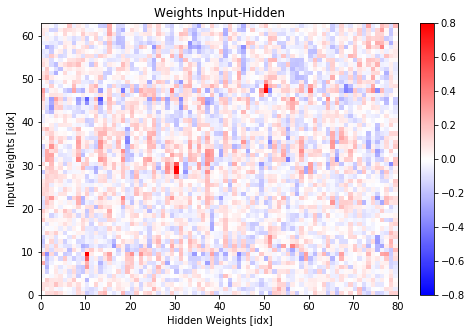

In [44]:
plt.figure(figsize=(8, 5))
plt.pcolormesh(weight_ih.transpose(), cmap='bwr')
clim = 0.8#np.max(np.abs(weight_hh))
plt.clim(-clim, clim)
plt.colorbar(), plt.title('Weights Input-Hidden')
plt.xlabel('Hidden Weights [idx]')
plt.ylabel('Input Weights [idx]')
plt.show()

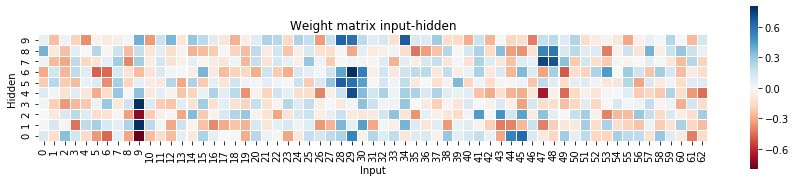

In [54]:
fig, ax= plt.subplots(figsize = (15, 3))
ax.set_title('Weight matrix input-hidden')
sns.heatmap(weight_ih,cmap='RdBu', vmin=-0.8, vmax=0.8, linewidths=0.01, square=True)
ax.set_ylabel('Hidden'), ax.set_xlabel('Input')
ax.invert_yaxis()
fig.savefig('fig_0422_weights_ih.png')

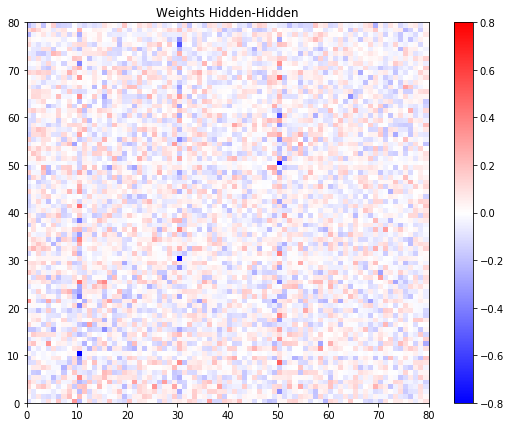

In [45]:
plt.figure(figsize=(9, 7))
plt.pcolormesh(weight_hh, cmap='bwr')
clim = 0.8#np.max(np.abs(weight_hh))
plt.clim(-clim, clim)
plt.colorbar(), plt.title('Weights Hidden-Hidden')
plt.show()

In [38]:
plt.figure(figsize=(9, 0.3))
plt.pcolormesh(weight_ho, cmap='Greys')
plt.colorbar(), plt.title('Weights Hidden-Output')
plt.show()

NameError: name 'weight_ho' is not defined

<Figure size 648x21.6 with 0 Axes>

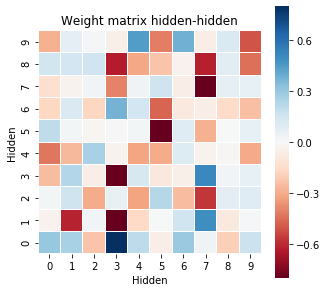

In [55]:
#sns.clustermap(X_train[0][0:20].numpy())
fig, ax= plt.subplots(figsize = (5, 5))
ax.set_title('Weight matrix hidden-hidden')
sns.heatmap(weight_hh,cmap='RdBu', vmin=-0.8, vmax=0.8, linewidths=0.01, square=True)
ax.set_ylabel('Hidden'), ax.set_xlabel('Hidden')
ax.invert_yaxis()
fig.savefig('fig_0422_weights_hh.png')

In [73]:
X_train[0].shpe

torch.Size([50, 76])

In [11]:
fig.savefig('.\doc\figures\fig_0422_predictions_rnn.png')